In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
import numpy as np
data = np.load('combine_oneTimeStepPerSample_79_z_and_kdp_4classes_colorFirst.npy', encoding='bytes')
data.shape


(79, 1, 1, 150, 200, 40)

In [ ]:
label = np.load('combineLabel_oneTimeStepPerSample_79_4classes_colorFirst.npy', encoding='bytes')
label.shape

(79, 1, 1, 150, 200, 1)

In [ ]:
np.unique(label, return_counts=True)

(array([0., 1., 2., 3.]), array([981491, 348666, 445530, 594313]))

In [ ]:
len(data)

79

In [ ]:
nValid = 4
nTest = 1
nTrain = len(data) - nValid - nTest

X_train, Y_train = data[:nTrain], label[:nTrain]
X_valid, Y_valid = data[nTrain:nTrain + nValid], label[nTrain:nTrain + nValid]
X_test, Y_test = data[nTrain + nValid:nTrain + nValid + nTest], label[nTrain + nValid:nTrain + nValid + nTest]

In [ ]:
X_train.shape, Y_train.shape

((74, 1, 1, 150, 200, 40), (74, 1, 1, 150, 200, 1))

In [ ]:
X_valid.shape, Y_valid.shape

((4, 1, 1, 150, 200, 40), (4, 1, 1, 150, 200, 1))

In [ ]:
X_test.shape, Y_test.shape

((1, 1, 1, 150, 200, 40), (1, 1, 1, 150, 200, 1))

In [ ]:
np.unique(Y_train, return_counts=True), np.unique(Y_valid, return_counts=True), np.unique(Y_test, return_counts=True)

((array([0., 1., 2., 3.]), array([900229, 322279, 429760, 567732])),
 (array([0., 1., 2., 3.]), array([64530, 21150, 12677, 21643])),
 (array([0., 1., 2., 3.]), array([16732,  5237,  3093,  4938])))

In [ ]:
sample, time, color, rows ,cols, depths = X_train.shape

In [ ]:

sample, time, color,  rows ,cols, depths

(74, 1, 1, 150, 200, 40)

In [ ]:
from tensorflow.keras import regularizers
model_2 = keras.models.Sequential([

    keras.layers.ConvLSTM3D(filters = 30, 
                            kernel_size = (2, 2, 2), 
                            strides = (1,1,1),
                            padding = "same",
                            return_sequences = True, 
                            input_shape = (None, color,  rows ,cols, depths),
                            dropout = 0.2,
                            kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
                            data_format='channels_last'),
    tf.keras.layers.LayerNormalization(axis=[-3,-2]),
    keras.layers.ConvLSTM3D(filters = 10, 
                            kernel_size = (2, 2, 2), 
                            strides = (1,1,1),
                            padding = "same",
                            return_sequences = True, 
                            dropout = 0.1,
                            recurrent_dropout = 0.0,
                            kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
                            ),
    tf.keras.layers.LayerNormalization(axis=[-3,-2]),
    keras.layers.ConvLSTM3D(filters = 10, 
                            kernel_size = (2, 2, 2), 
                            strides = (1,1,1),
                            padding = "same",
                            return_sequences = True, 
                            dropout = 0.1,
                            kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
                            ),
    
    tf.keras.layers.LayerNormalization(axis=[-3,-2]),
    tf.keras.layers.Dense(5, activation = 'softmax') 
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
#lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#    initial_learning_rate, decay_steps = 100000, alpha=0.01, name=None)
#weights = [1,2,3,6,8]
#lossWeights[:] = [w/sum(weights) for w in weights]
optimizer = keras.optimizers.Adam(learning_rate= lr_schedule)
model_2.compile(
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizer,
              #loss_weights = lossWeights,
              metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
              
              )



In [ ]:
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm3d_3 (ConvLSTM3D)  (None, None, 1, 150, 200  67320     
                             , 30)                               
                                                                 
 layer_normalization_3 (Laye  (None, None, 1, 150, 200  60000    
 rNormalization)             , 30)                               
                                                                 
 conv_lstm3d_4 (ConvLSTM3D)  (None, None, 1, 150, 200  12840     
                             , 10)                               
                                                                 
 layer_normalization_4 (Laye  (None, None, 1, 150, 200  60000    
 rNormalization)             , 10)                               
                                                                 
 conv_lstm3d_5 (ConvLSTM3D)  (None, None, 1, 150, 200 

In [ ]:
import os
checkpoint_path = "reports/convLSTM3D_150_200_79_4classes_dropout.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,  monitor='val_loss',save_best_only= True,)
history = model_2.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[checkpoint_cb])

Epoch 1/100
3/3 [==============================] - 12s 2s/step - loss: 2.7955 - sparse_categorical_accuracy: 0.2328 - val_loss: 1.7024 - val_sparse_categorical_accuracy: 0.6281
Epoch 2/100
3/3 [==============================] - 3s 822ms/step - loss: 1.6256 - sparse_categorical_accuracy: 0.5779 - val_loss: 1.4175 - val_sparse_categorical_accuracy: 0.6645
Epoch 3/100
3/3 [==============================] - 3s 794ms/step - loss: 1.4062 - sparse_categorical_accuracy: 0.6181 - val_loss: 1.4205 - val_sparse_categorical_accuracy: 0.6713
Epoch 4/100
3/3 [==============================] - 3s 798ms/step - loss: 1.3973 - sparse_categorical_accuracy: 0.6249 - val_loss: 1.4353 - val_sparse_categorical_accuracy: 0.6707
Epoch 5/100
3/3 [==============================] - 3s 829ms/step - loss: 1.3778 - sparse_categorical_accuracy: 0.6408 - val_loss: 1.3995 - val_sparse_categorical_accuracy: 0.6830
Epoch 6/100
3/3 [==============================] - 3s 831ms/step - loss: 1.3439 - sparse_categorical_accura

In [ ]:
history.history

{'loss': [2.79545521736145,
  1.625596284866333,
  1.4062398672103882,
  1.3973207473754883,
  1.377780556678772,
  1.3439099788665771,
  1.2891764640808105,
  1.256246566772461,
  1.2210564613342285,
  1.187748670578003,
  1.1573606729507446,
  1.1348718404769897,
  1.107162594795227,
  1.0770477056503296,
  1.0547232627868652,
  1.0374093055725098,
  1.0156009197235107,
  1.0007835626602173,
  0.9858928322792053,
  0.9753309488296509,
  0.9686304926872253,
  0.952137291431427,
  0.9435441493988037,
  0.9372377395629883,
  0.9267652630805969,
  0.9157399535179138,
  0.9156907796859741,
  0.9207188487052917,
  0.9070559144020081,
  0.9142189025878906,
  0.9168614745140076,
  0.9151424765586853,
  0.9091306328773499,
  0.9007980823516846,
  0.9091695547103882,
  0.903928279876709,
  0.9000314474105835,
  0.899476945400238,
  0.902845025062561,
  0.8997801542282104,
  0.896746039390564,
  0.8950290083885193,
  0.8888828158378601,
  0.8835744261741638,
  0.8808535933494568,
  0.8766387701

In [ ]:
y_pred = model_2.predict(X_test)

In [ ]:

y_pred.shape


In [ ]:
y_pred_class = np.argmax(y_pred, axis = -1)
y_pred_class_plot = y_pred_class.reshape(150,200)

In [ ]:
np.unique(y_pred_class, return_counts=True), np.unique(Y_test, return_counts=True)

((array([0, 1, 2, 3]), array([16069,  3414,  2695,  7822])),
 (array([0., 1., 2., 3.]), array([16732,  5237,  3093,  4938])))

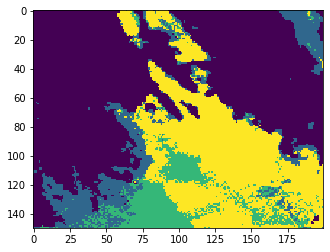

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(y_pred_class_plot, interpolation='none')
plt.show()

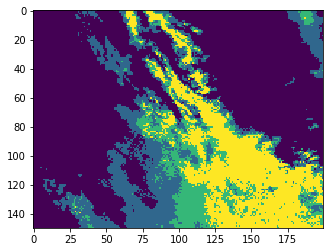

In [ ]:
Y_test_plot = Y_test.reshape(150,200)
plt.imshow(Y_test_plot, interpolation='none')
plt.show()